### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras import Sequential, regularizers
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  0


### Load Datasets & Data Preprocessing

#### Description of features
- **WDIR**: Wind direction
- **WSPD**: Wind speed
- **WSPD_T**: Transformed wind speed
- **rWSPD**: Lagged wind speed
- **rWSPD_T**: Transformed lagged wind speed (for sikorsky)
- **Fetch**: Fetch distance

#### Description of target
- **SWHft**: Significant wave height (in feet)

In [3]:
WSPD = 'WSPD_T' # {'WSPD','WSPD_T'}

df_buoy_04_13 = pd.read_csv('Data_Buoy_2004_2013.csv')
df_stn_04_13 = pd.read_csv('Data_Sikorsky_2004_2013.csv')
df_stn_04_13['WSPD_T'] = df_stn_04_13['rWSPD_T'].shift(-1).ffill()

df1 = pd.concat([df_buoy_04_13[['TimeStamp_1','SWHft']], df_stn_04_13[[WSPD,'Fetch']]], axis=1)

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)

# Train-Test split
seperate_date = pd.to_datetime('2005-10-31 23:59:00')
df_train = df1[df1.index > seperate_date]  # From 2005-11-01 00:00:00 to 2013-10-31 23:00:00
df_test = df1[df1.index < seperate_date]   # From 2004-11-01 00:00:00 to 2005-10-31 23:00:00

# Data normalization
scaler_wave = MinMaxScaler()
scaler_wind = MinMaxScaler()

df_train = df_train.copy()
df_test = df_test.copy()

# Normalize wave height in the first dataset
df_train.loc[:, 'scaled_SWHft'] = scaler_wave.fit_transform(df_train[['SWHft']])
df_test.loc[:, 'scaled_SWHft'] = scaler_wave.transform(df_test[['SWHft']])

# Normalize WSPD and fetch in both datasets
df_train.loc[:, ['scaled_WSPD', 'scaled_Fetch']] = scaler_wind.fit_transform(df_train[[WSPD, 'Fetch']])
df_test.loc[:, ['scaled_WSPD', 'scaled_Fetch']] = scaler_wind.transform(df_test[[WSPD, 'Fetch']])

df_train.head()

,SWHft,WSPD_T,Fetch,scaled_SWHft,scaled_WSPD,scaled_Fetch
TimeStamp_1,,,,,,
2005-11-01 00:00:00,1.640420,6.56483,16093.4,0.161290,0.274244,0.042553
2005-11-01 01:00:00,1.968504,4.62640,16093.4,0.193548,0.171038,0.042553
2005-11-01 02:00:00,1.968504,4.94865,16093.4,0.193548,0.188195,0.042553
2005-11-01 03:00:00,1.640420,4.62640,16093.4,0.161290,0.171038,0.042553
2005-11-01 04:00:00,1.312336,5.77390,16093.4,0.129032,0.232133,0.042553


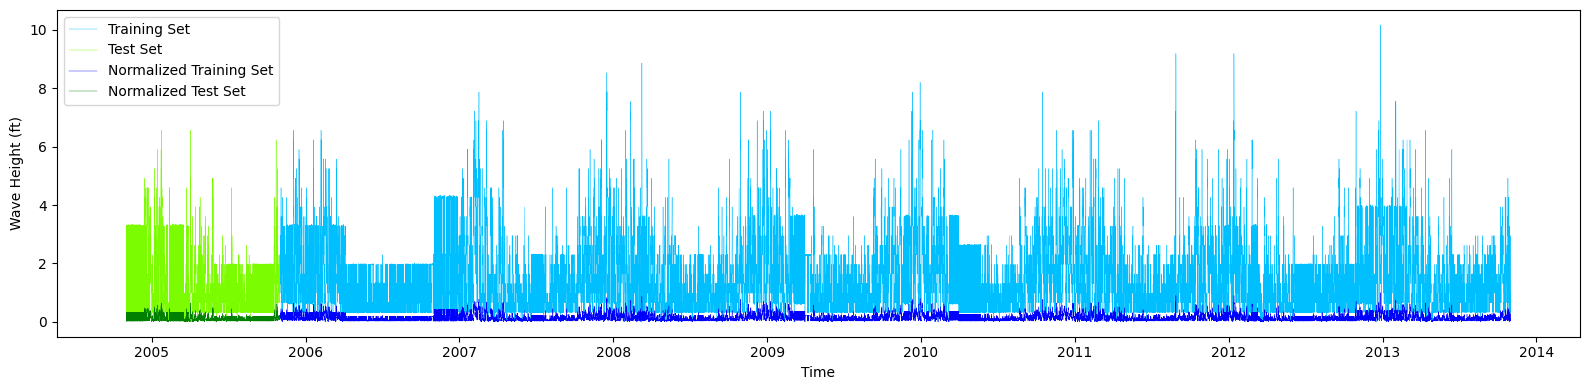

In [4]:
# Training and test data visualization
plt.figure(figsize=(16, 4))
plt.plot(df_train['SWHft'], linewidth=0.3, color='deepskyblue', label='Training Set')
plt.plot(df_test['SWHft'], linewidth=0.3, color='lawngreen', label='Test Set')
plt.plot(df_train['scaled_SWHft'], linewidth=0.3, color='b', label='Normalized Training Set')
plt.plot(df_test['scaled_SWHft'], linewidth=0.3, color='g', label='Normalized Test Set')

plt.xlabel('Time')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()

### Data Preparation: Train-Test-Validation Split

In [5]:
time_step = 12  # Use the previous time steps data to predict the next wave height
features = ['scaled_SWHft', 'scaled_WSPD', 'scaled_Fetch']

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        # X.append(data[i:(i+time_step), 1:])   # Past hours (WSPD, fetch)
        X.append(data[i:(i+time_step+1), 1:]) # (Past + current) hours (WSPD, fetch)
        y.append(data[i+time_step, 0])        # Next hour wave height
    return np.array(X), np.array(y)

# Training set: 2006-11-01 00:00:00 to 2013-10-31 23:00:00
# Validation set: 2005-11-01 00:00:00 to 2006-10-31 23:00:00
seperate_date = pd.to_datetime('2006-10-31 23:59:00')
df_split1 = df_train[df_train.index > seperate_date]
df_split2 = df_train[df_train.index < seperate_date]

X_train, y_train = create_sequences(df_split1[features].values, time_step)
X_val, y_val = create_sequences(df_split2[features].values, time_step)
X_test, y_test = create_sequences(df_test[features].values, time_step)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(61356, 13, 2)
(8748, 13, 2)
(8748, 13, 2)


### Model Selection and Implementation

Epoch 1/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0157 - mse: 0.0116 - val_loss: 0.0078 - val_mse: 0.0073
Epoch 2/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0089 - mse: 0.0085 - val_loss: 0.0084 - val_mse: 0.0081
Epoch 3/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - mse: 0.0084 - val_loss: 0.0068 - val_mse: 0.0066
Epoch 4/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0086 - mse: 0.0084 - val_loss: 0.0074 - val_mse: 0.0071
Epoch 5/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0087 - mse: 0.0084 - val_loss: 0.0076 - val_mse: 0.0074
Epoch 6/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0088 - mse: 0.0085 - val_loss: 0.0081 - val_mse: 0.0079
Epoch 7/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0086 - mse: 0.0083 - val_loss: 0.0066 - val_mse: 0.0064
Epoch 8/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - mse: 0.0084 - val_loss: 0.0070 - val_mse: 0.0067
Epoch 9/50
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - lo

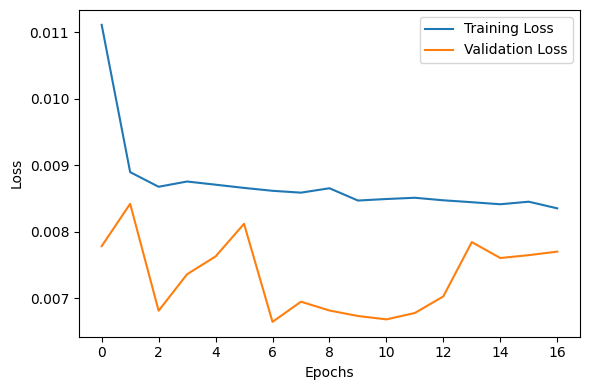

In [6]:
epochs = 50
batch_size = 128
model_file = 'model_1.keras'

# Model architecture
def create_model(X_train):
    model = Sequential([
        # Input layer with shape: (samples, time_steps, features)
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        
        # LSTM layers
        LSTM(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01), dropout=0.2, return_sequences=False),
        
        # Output layer
        Dense(1),
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00664231939581146), loss='mse', metrics=['mse'])
    
    return model

# Train and save the model (architecture + weights)
model = create_model(X_train)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

In [7]:
# Load the saved model
model = load_model(model_file)

# Training error
y_pred1 = model.predict(X_train, verbose=0)
y_pred1_original = scaler_wave.inverse_transform(y_pred1)
mse1 = mean_squared_error(df_split1['SWHft'][time_step:], y_pred1_original)
print(f'Training RMSE: {np.sqrt(mse1):.3f}')

# Validation error
y_pred2 = model.predict(X_val, verbose=0)
y_pred2_original = scaler_wave.inverse_transform(y_pred2)
mse2 = mean_squared_error(df_split2['SWHft'][time_step:], y_pred2_original)
print(f'Validation RMSE: {np.sqrt(mse2):.3f}')

# Test error
y_pred3 = model.predict(X_test, verbose=0)
y_pred3_original = scaler_wave.inverse_transform(y_pred3)
mse3 = mean_squared_error(df_test['SWHft'][time_step:], y_pred3_original)
print(f'Test RMSE: {np.sqrt(mse3):.3f}')

Training RMSE: 0.883
Validation RMSE: 0.813
Test RMSE: 0.958


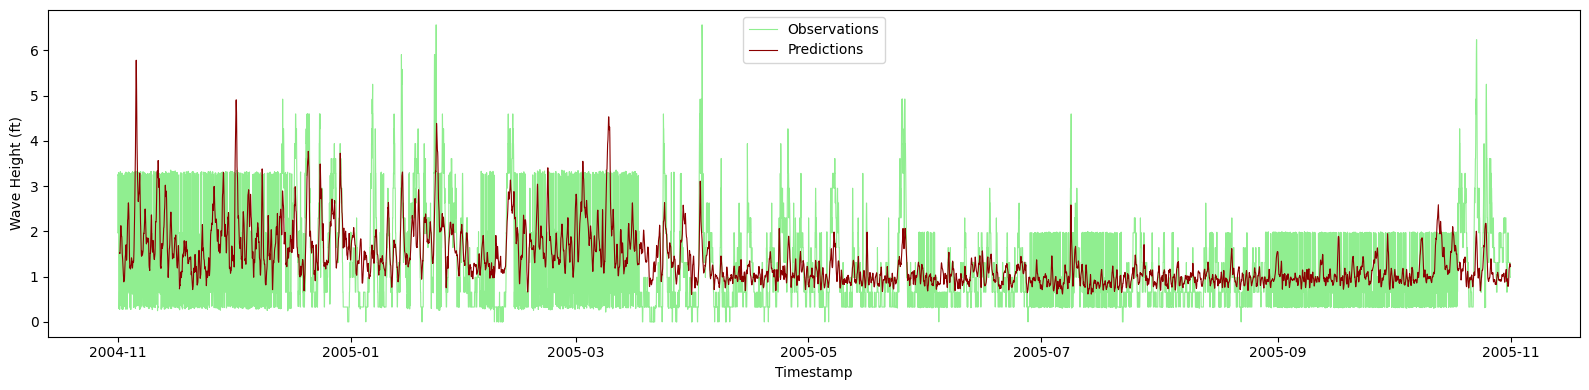

In [8]:
# Test Error Visualization
plt.figure(figsize=(16, 4))
plt.plot(df_test.index, df_test['SWHft'], linewidth=0.8, color='lightgreen', label='Observations')
plt.plot(df_test.index[time_step:], y_pred3_original, linewidth=0.8, color='darkred', label='Predictions')

plt.xlabel('Timestamp')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()